In [17]:
# mlp_regression_from_latent.ipynb

# Section 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# === [OPTIONAL] Generate synthetic data for testing ===
# Comment this out if using real data

import numpy as np

In [18]:
# Section 2: Load Latent Space data
# Replace with your actual .npy file paths

## Z = np.load("Z_features.npy")        # Shape: (N, 13)

LS_data = np.load('LS_2Dch2_am_vx_sl134_LD13_bs600.npy', allow_pickle=True)

### Access arrays from the dictionary
LSp = LS_data.item().get('LSp')  ## latent space points, Shape: (N, 13)
LA = LS_data.item().get('LA')    ## labels, Shape: (N, 2)

LD = LSp.shape[1]  ### latent dimension

print('LD =', LD,'; LSp.shape =', LSp.shape,)

LA = LA[:, 0] ## for 2-channel
print('LA (shape) =', LA.shape, ', LA[-1] =', LA[-1])

###----------- 9 digit labels---------------
## Parse the labels to get the LA_id, LA_IC and LA_tt
LA_id = np.array([int(str(x)[1:3]) for x in LA]) # 2nd & 3rd digit (index 1 & 2) of LA for LA_id

Sr_inp = np.array([0.01, 0.01, 0.00, 0.05, 0.05])
sigA_inp = np.array([50, 100, 80, 80, 100])

## Assign the Sr, sigma_A to the N points in LS, indexed according to LA_id
Sr = Sr_inp[LA_id]         # Shape: (N,)
sigA = sigA_inp[LA_id]     # Shape: (N,)

## Stack the arrays [Sr, sigA] side-by-side to a 2-column array
y = np.stack([Sr, sigA], axis=1).astype(np.float32)
print(y.shape)

LD = 13 ; LSp.shape = (144000, 13)
LA (shape) = (144000,) , LA[-1] = 903140976
(144000, 2)


In [19]:
# Section 2: Load Latent Space data
# Replace with your actual .npy file paths

## Z = np.load("Z_features.npy")        # Shape: (N, 13)

LS_data = np.load('LS_2Dch2_am_vx_Sr0pt02_sl191_LD3_bs600.npy', allow_pickle=True)

### Access arrays from the dictionary
LSp_B = LS_data.item().get('LSp')  ## latent space points, Shape: (N, 13)
LA = LS_data.item().get('LA')    ## labels, Shape: (N, 2)

LD = LSp.shape[1]  ### latent dimension

print('LD =', LD,'; LSp.shape =', LSp.shape,)

LA = LA[:, 0] ## for 2-channel
print('LA (shape) =', LA.shape, ', LA[-1] =', LA[-1])

###----------- 9 digit labels---------------
## Parse the labels to get the LA_id, LA_IC and LA_tt
LA_id = np.array([int(str(x)[1:3]) for x in LA]) # 2nd & 3rd digit (index 1 & 2) of LA for LA_id

Sr_inp = np.array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02])
sigA_inp = np.array([50, 60, 70, 80, 90, 100])

## Assign the Sr, sigma_A to the N points in LS, indexed according to LA_id
Sr_B = Sr_inp[LA_id]         # Shape: (N,)
sigA_B = sigA_inp[LA_id]     # Shape: (N,)



LD = 13 ; LSp.shape = (144000, 13)
LA (shape) = (172800,) , LA[-1] = 903070197


In [20]:
Z = np.concatenate((LSp, LSp_B), axis=0)

In [21]:
Sr_2 = np.concatenate((Sr, Sr_B),axis=0)
sigA_2 = np.concatenate((sigA, sigA_B),axis=0)

In [22]:
a = Sr_2*100 + 1 # from 0.00,0.01,0.02,0.05 into 1,2,3,6
b = sigA_2/10 -4 # from 50-100 into 1-6

y = np.stack([a, b], axis=1).astype(np.float32)


(array([ 28790.,      0.,  57647.,      0., 172800.,      0.,      0.,
             0.,      0.,  57563.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

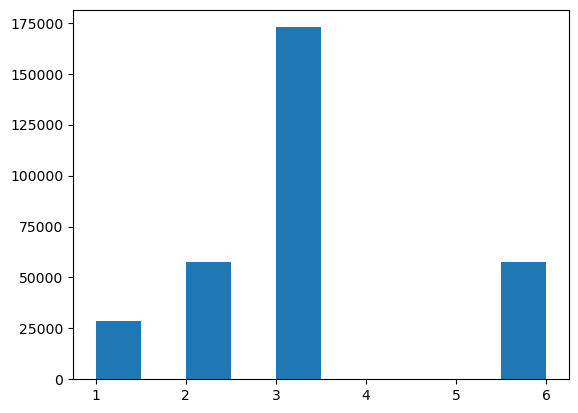

In [23]:
plt.hist(a)


(array([57683.,     0., 28915.,     0., 28799.,     0., 86544.,     0.,
        28724., 86135.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

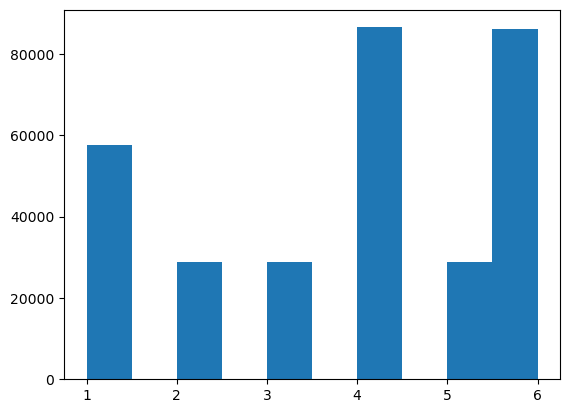

In [24]:
plt.hist(b)


In [25]:

# Section 3: Train-validation split
Z_train, Z_val, y_train, y_val = train_test_split(Z, y, test_size=0.2, random_state=42)

# Section 4: Dataset and DataLoader
class LatentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(LatentDataset(Z_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(LatentDataset(Z_val, y_val), batch_size=32)


In [26]:
def add_noise_to_targets(y, std_a=0.5, std_b=0.5):
    noise_a = torch.normal(mean=0.0, std=std_a, size=y[:, 0].shape, device=y.device)
    noise_b = torch.normal(mean=0.0, std=std_b, size=y[:, 1].shape, device=y.device)
    y_noisy = y.clone()
    y_noisy[:, 0] += noise_a
    y_noisy[:, 1] += noise_b
    return y_noisy

def soft_quantized_mse(pred, true, anchors, weight=0.5):
    mse = (pred - true) ** 2
    anchor_loss = torch.min(torch.stack([(pred - a)**2 for a in anchors], dim=0), dim=0)[0]
    return mse.mean() + weight * anchor_loss.mean()


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

# ---- Section 5: Define MLP Model ----
class MLPRegressor(nn.Module):
    def __init__(self, in_dim=13, hidden_dim=64, out_dim=2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, out_dim),
            nn.Softplus()  # Ensures both outputs are strictly positive
        )

    def forward(self, x):
        return self.mlp(x)


# Anchors for parameters a and b
anchors_a = [1,2,3,6]
anchors_b = [1,2,3,4,5,6]


model = MLPRegressor()

# L2 regularization via weight_decay
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# MSE loss (assuming y is already transformed with log(x + 0.01) + 5)
criterion = nn.MSELoss()

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Early stopping parameters
early_stop_patience = 50
best_val_loss = float('inf')
early_stop_counter = 0

# ---- Section 6: Training Loop ----
num_epochs = 200
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:

        # Apply noise to both parameters
        yb_noisy = add_noise_to_targets(yb, std_a=0.5, std_b=0.5)

        pred = model(xb)

        # Soft anchor loss for both parameters
        loss_a = soft_quantized_mse(pred[:, 0], yb_noisy[:, 0], anchors=anchors_a)
        loss_b = soft_quantized_mse(pred[:, 1], yb_noisy[:, 1], anchors=anchors_b)

        loss = loss_a + loss_b

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * xb.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss_a = soft_quantized_mse(pred[:, 0], yb[:, 0], anchors=anchors_a)
            loss_b = soft_quantized_mse(pred[:, 1], yb[:, 1], anchors=anchors_b)
            loss = loss_a + loss_b
            total_val_loss += loss.item() * xb.size(0)
            
    avg_val_loss = total_val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # Learning rate schedule step
    scheduler.step(avg_val_loss)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        best_model_state = model.state_dict()
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {avg_train_loss:.4f} — Val Loss: {avg_val_loss:.4f}")

# Restore best model
model.load_state_dict(best_model_state)


Epoch 1/200 — Train Loss: 1.3724 — Val Loss: 0.3593
Epoch 2/200 — Train Loss: 1.0458 — Val Loss: 0.3536
Epoch 3/200 — Train Loss: 0.9763 — Val Loss: 0.3898
Epoch 4/200 — Train Loss: 0.9389 — Val Loss: 0.3019
Epoch 5/200 — Train Loss: 0.9161 — Val Loss: 0.2950
Epoch 6/200 — Train Loss: 0.9054 — Val Loss: 0.2770
Epoch 7/200 — Train Loss: 0.8886 — Val Loss: 0.2691
Epoch 8/200 — Train Loss: 0.8829 — Val Loss: 0.2586
Epoch 9/200 — Train Loss: 0.8687 — Val Loss: 0.2758
Epoch 10/200 — Train Loss: 0.8652 — Val Loss: 0.2386
Epoch 11/200 — Train Loss: 0.8534 — Val Loss: 0.2624
Epoch 12/200 — Train Loss: 0.8539 — Val Loss: 0.2401
Epoch 13/200 — Train Loss: 0.8522 — Val Loss: 0.2582
Epoch 14/200 — Train Loss: 0.8467 — Val Loss: 0.2377
Epoch 15/200 — Train Loss: 0.8376 — Val Loss: 0.2224
Epoch 16/200 — Train Loss: 0.8352 — Val Loss: 0.2363
Epoch 17/200 — Train Loss: 0.8287 — Val Loss: 0.1984
Epoch 18/200 — Train Loss: 0.8297 — Val Loss: 0.2253
Epoch 19/200 — Train Loss: 0.8241 — Val Loss: 0.2003
Ep

<All keys matched successfully>

In [28]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_loss': best_val_loss,
}, '/mnt/d/lding/UbuntuGitCodes/actomyosin_modeling/actomyosin_autoencoders_tf2.0/mlp_results/mlp_best_model_full_20250418.pth')

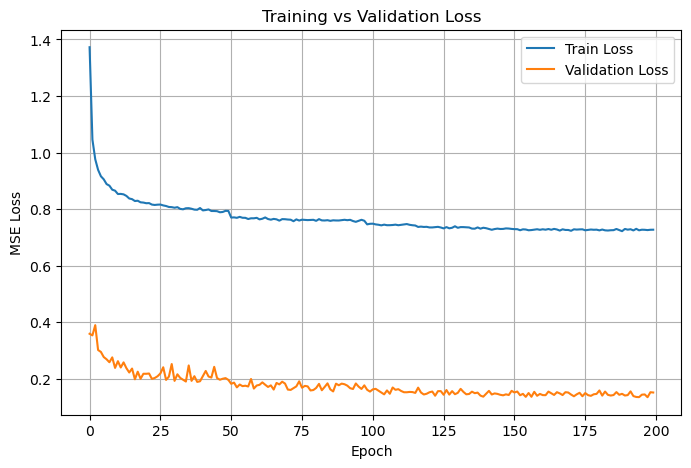

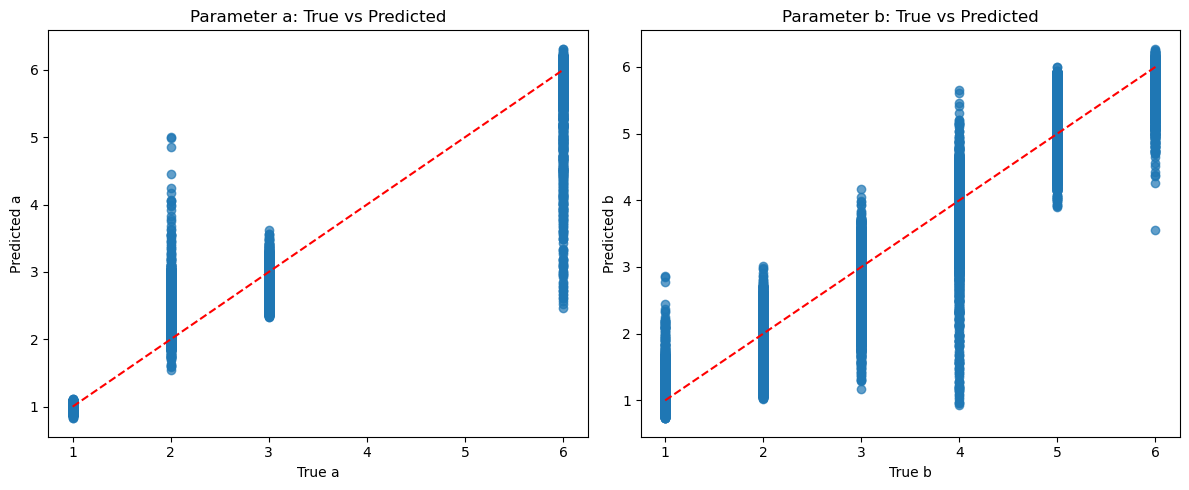

In [29]:

# Section 7: Plot training/validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

# Section 8: Evaluate predictions
model.eval()
with torch.no_grad():
    val_preds = model(torch.tensor(Z_val, dtype=torch.float32)).numpy()

# Section 9: Plot predictions vs ground truth
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(y_val[:, 0], val_preds[:, 0], alpha=0.7)
axs[0].plot([y_val[:, 0].min(), y_val[:, 0].max()],
            [y_val[:, 0].min(), y_val[:, 0].max()], 'r--')
axs[0].set_title("Parameter a: True vs Predicted")
axs[0].set_xlabel("True a")
axs[0].set_ylabel("Predicted a")

axs[1].scatter(y_val[:, 1], val_preds[:, 1], alpha=0.7)
axs[1].plot([y_val[:, 1].min(), y_val[:, 1].max()],
            [y_val[:, 1].min(), y_val[:, 1].max()], 'r--')
axs[1].set_title("Parameter b: True vs Predicted")
axs[1].set_xlabel("True b")
axs[1].set_ylabel("Predicted b")

plt.tight_layout()
plt.show()

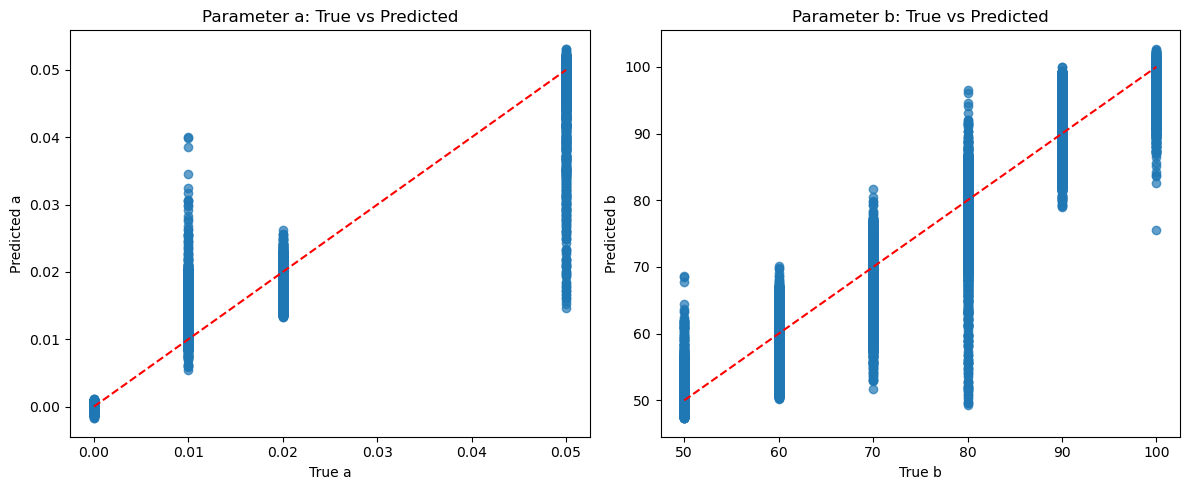

In [30]:
# Section 9: Plot predictions vs ground truth
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
a = Sr_2*100 + 1 # from 0.00,0.01,0.02,0.05 into 1,2,3,6
b = sigA_2/10 -4 # from 50-100 into 1-6

axs[0].scatter((y_val[:, 0]-1)*0.01, (val_preds[:, 0]-1)*0.01, alpha=0.7)
axs[0].plot([((y_val[:, 0]-1)*0.01).min(), ((y_val[:, 0]-1)*0.01).max()],
            [((y_val[:, 0]-1)*0.01).min(), ((y_val[:, 0]-1)*0.01).max()], 'r--')
axs[0].set_title("Parameter a: True vs Predicted")
axs[0].set_xlabel("True a")
axs[0].set_ylabel("Predicted a")

axs[1].scatter((y_val[:, 1]+4)*10, (val_preds[:, 1]+4)*10, alpha=0.7)
axs[1].plot([(y_val[:, 1].min()+4)*10, (y_val[:, 1].max()+4)*10],
            [(y_val[:, 1].min()+4)*10, (y_val[:, 1].max()+4)*10], 'r--')
axs[1].set_title("Parameter b: True vs Predicted")
axs[1].set_xlabel("True b")
axs[1].set_ylabel("Predicted b")

plt.tight_layout()
plt.show()